Okay, lets try a word embedding model. Hopefully this will be a bit more robust than the first model I played with, since the words are better represented than with a simple tokenizer. The basic model preformed adequately, so I'm not too concerned about it. I think applying GloVe embeddings will give the model the boost to be really powerful.

Honestly my main concern is packaging the model for Heroku, since GloVe vectors are huge. I'm thinking I can train a model here, load it in a heroku app and then dockerize the entire thing.

First lets import our Libraries and Dataset.

In [59]:
%matplotlib inline

import os
import sys
import numpy as np
import pandas as pd
import csv
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import Flatten
from keras.models import Model, Sequential
from keras.models import load_model
import pickle

In [2]:
#Setup a few helpers
base_dir = ''
glove_dir = os.path.join(base_dir, 'glove.6B')
max_seq_len = 1000
max_num_words = 20000
embedding_dim = 100
validation_split = 0.2

In [3]:
#load the data into pandas for easy handling
data = pd.read_csv('train.csv')

In [4]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
def encode_label_sum(integer):
    if integer > 0:
        return 1
    return 0

In [5]:
#change to binary label indicating toxicity, this will give us a simpler model in the end
data['any_toxic'] = data[list_classes]\
.sum(axis = 1)\
.apply(encode_label_sum)

In [6]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,any_toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [7]:
#quick sanity check
data.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
any_toxic        False
dtype: bool

So we see our dataset is adequately clean (Kaggle sure is nice). ~~I've gone ahead and split the "testing" data into testing and training.~~ I'm going to finish preprocessing and then split the data so I don't have to do it twice. I want to test on a subset of the data so I can validate the model. Once I'm confident in it, I can submit predictions to Kaggle for out-of-sample validation. That said, this is a luxury I seldom have so I don't want to lean on it like a crutch. 

In [8]:
#lets chop up the data into the pieces we want
labels = data['any_toxic'].values
comments = data["comment_text"]

In [9]:
comments.head()

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object

In [10]:
comments.head()

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object

In [11]:
labels[:5]

array([0, 0, 0, 0, 0])

In [12]:
#You know, lets see how long these comments are in general
comments\
.apply(lambda x: len(x.split()))\
.describe()

count    159571.000000
mean         67.273527
std          99.230702
min           1.000000
25%          17.000000
50%          36.000000
75%          75.000000
max        1411.000000
Name: comment_text, dtype: float64

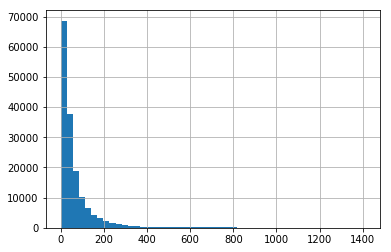

In [13]:
#some of those comments are crazy long, so lets get a birds eye view. 
comments\
.apply(lambda x: len(x.split()))\
.hist(bins=50)

Okay, the dataset looks pretty hunky-dory. Lets tokenize it and get some embeddings. 

In [14]:
#before we figure out embeddings, 
#I'm gonna adjust the arbitrarily selected sequence length paramaters to fit this dataset.
max_seq_len = 200 
#lets cut this down to 200 for shorter input tensors and less empty space,
#we won't be loosing much of the dataset and it'll train quicker
max_num_words = 20000
embedding_dim = 100
#vocab size and Embedding dims still seem okay

In [16]:
#tokenize the comments
comment_tokenizer = Tokenizer(num_words=max_num_words)
comment_tokenizer.fit_on_texts(list(comments))
sequences = comment_tokenizer.texts_to_sequences(list(comments))

comment_word_index = comment_tokenizer.word_index

In [17]:
print(f"We got {len(comment_word_index)} Words")

We got 210337 Words


In [18]:
data = pad_sequences(sequences, maxlen=max_seq_len)

In [19]:
labels = to_categorical(np.asarray(labels))

In [20]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (159571, 200)
Shape of label tensor: (159571, 2)


All the shapes check out, trying to fit 159571 comments of 200 words in length into six binary categories.

Now lets split off a validation set. 

In [21]:
data_train, data_test, labels_train, labels_test =\
train_test_split(data, labels, test_size = 0.2, random_state = 42)

In [22]:
data_train.shape

(127656, 200)

In [23]:
labels_train.shape

(127656, 2)

Good, all the preprocessing is complete. Lets start on embedding layers. First, gotta load them. 

In [24]:
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print(f'there\'s {len(embeddings_index)} embeddings.')

400000it [00:13, 30428.33it/s]

there's 400000 embeddings.


In [25]:
embedding_matrix = np.zeros((len(comment_word_index) + 1, embedding_dim))
for word, i in tqdm(comment_word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

100%|██████████| 210337/210337 [00:00<00:00, 440927.44it/s]


In [26]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.18970001,  0.050024  ,  0.19084001, ..., -0.39804   ,
         0.47646999, -0.15983   ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.07574   ,  0.42109001,  0.77687001, ...,  0.095977  ,
         1.62820005, -0.10819   ],
       [ 0.068997  , -0.31268999, -0.24092001, ..., -0.06305   ,
         0.52090001,  0.45936   ]])

In [27]:
embedding_layer = Embedding(len(comment_word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_seq_len,
                            trainable=False)

Now we have our embedding layer to start out net. Lets put together a model. 

In [28]:
sequence_input = Input(shape=(max_seq_len,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(3)(x)  # global max pooling
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(2, activation='softmax')(x)

model = Model(sequence_input, preds)
#lets save the bare model to disk for adjusting training hyper-params
model.save('models/untrained-model.h5')

Lets try a pilot training of this model using some random settings

In [29]:
model = load_model('models/untrained-model.h5')
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
hist_first = model.fit(data_train, labels_train, 
                       validation_data=(data_test, labels_test),
                       epochs=2, batch_size=128)
model.save('models/cat-cross-model-e2.h5')

/Users/Ben/miniconda3/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Train on 127656 samples, validate on 31915 samples
Epoch 1/2
127656/127656 [==============================] - 356s 3ms/step - loss: 0.1830 - acc: 0.9355 - val_loss: 0.1711 - val_acc: 0.9470
Epoch 2/2
127656/127656 [==============================] - 344s 3ms/step - loss: 0.1407 - acc: 0.9500 - val_loss: 0.1384 - val_acc: 0.9530


In [34]:
print(type(hist_first.validation_data))
print(type(hist_first.history))

<class 'list'>
<class 'dict'>


lets try a binary loss function now, hopefully it will help the model discern between toxic or not (as opposed to different species of toxic) with a bit more accuracy. 

In [31]:
model = load_model('models/untrained-model.h5')
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])
hist_bin_2 = model.fit(data_train, labels_train, 
                       validation_data=(data_test, labels_test),
                       epochs=2, batch_size=128)
model.save('models/binary-crossentropy-e2.h5')

/Users/Ben/miniconda3/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Train on 127656 samples, validate on 31915 samples
Epoch 1/2
127656/127656 [==============================] - 360s 3ms/step - loss: 0.1668 - acc: 0.9391 - val_loss: 0.1431 - val_acc: 0.9506
Epoch 2/2
127656/127656 [==============================] - 351s 3ms/step - loss: 0.1288 - acc: 0.9528 - val_loss: 0.1316 - val_acc: 0.9531


In [44]:
df2 = pd.DataFrame(hist_bin_2.history)

So our binary classifier has 95% accuracy. Thats a decent bump just by changing the loss function. Lets train it for a few more epochs and see if we can push the metrics a bit higher. 

In [32]:
hist_bin_5 = model.fit(data_train, labels_train, 
                       validation_data=(data_test, labels_test),
                       epochs=3, batch_size=128)
model.save('toxic-classifier-binary-e5.h5')

Train on 127656 samples, validate on 31915 samples
Epoch 1/3
127656/127656 [==============================] - 356s 3ms/step - loss: 0.1134 - acc: 0.9579 - val_loss: 0.1298 - val_acc: 0.9547
Epoch 2/3
127656/127656 [==============================] - 400s 3ms/step - loss: 0.0976 - acc: 0.9637 - val_loss: 0.1361 - val_acc: 0.9528
Epoch 3/3
127656/127656 [==============================] - 418s 3ms/step - loss: 0.0836 - acc: 0.9691 - val_loss: 0.1472 - val_acc: 0.9470


In [43]:
df5 = pd.DataFrame(hist_bin_5.history)

In [45]:
df2

,acc,loss,val_acc,val_loss
0,0.939149,0.166758,0.950587,0.143127
1,0.952819,0.128785,0.953063,0.131630


In [46]:
df5

,acc,loss,val_acc,val_loss
0,0.957926,0.113395,0.954661,0.129827
1,0.963691,0.097629,0.952781,0.136143
2,0.969065,0.083605,0.947047,0.147227


In [53]:
bin_hist = pd.concat([df2, df5])

In [54]:
bin_hist.reset_index(inplace=True, drop=True)

In [55]:
bin_hist

,acc,loss,val_acc,val_loss
0,0.939149,0.166758,0.950587,0.143127
1,0.952819,0.128785,0.953063,0.131630
2,0.957926,0.113395,0.954661,0.129827
3,0.963691,0.097629,0.952781,0.136143
4,0.969065,0.083605,0.947047,0.147227


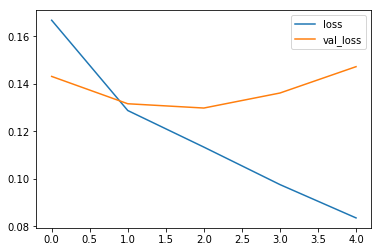

In [57]:
bin_hist[['loss','val_loss']].plot()

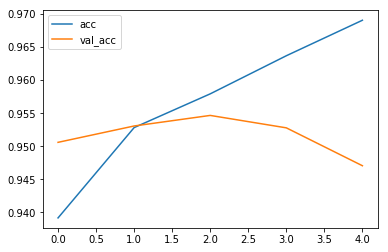

In [58]:
bin_hist[['acc','val_acc']].plot()

While these plots are not the most telling, we can see that the validation loss and accuracy appear to begin faltering at two epochs. I'm glad I generated these plots because otherwise I would have used the five epoch model (which is likely overfitted) in production. Now we know that the two epoch model has a preferably out of sample loss and accuracy. 

Last things last, lets grab the tokenizer we fitted earlier, as the web app will need that. 

In [60]:
pickle.dump(comment_tokenizer, open('models/comment-tokenizer.pkl', 'wb'))